## assetCode with MDA using random data

In the kernel "The fallacy of encoding assetCode", @marketneutral makes the point that encoding assetCode and using either of the lightGBM built in feature importances (split and gain) results in assetCode being a significant feature. The advice was "Don't encode assetCode".

In this kernel, we experiment with using MDA feature importances as described in "Advances in Financial Machine Learning" by Marcos Lopez de Prado.

We use the code from @marketneutral's kernel to generate random data for the test.

Using this process, assetCode has no importance.

In [1]:
import numpy as np
#import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'shap'

In [8]:
#!pip install pandas-ta 

  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218925 sha256=5445b20420ee277d978a7a84d465bf7f1203119605c3466bfb40f9eaaa4fe315
  Stored in directory: c:\users\donov\appdata\local\pip\cache\wheels\54\4a\75\06b8e63fce6f6d2c1baae5c208edb18eca128407b0c96e1153
Successfully built pandas-ta


In [ ]:
#!conda install shap

In [9]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas_ta as pdta
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
#os.chdir(r'C:\Users\donov\Downloads\Northwestern\MSDS 451 - Financial ML\Anaconda Working Dir')
import itertools
from itertools import product
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error, log_loss

from tensorflow.keras.utils import to_categorical

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:

np.random.seed(0)
# Fractional differntiation code snippets from Dr. Ernie P Chan and Dr. Roger Hunter
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_=pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x=pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x=x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df   

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0


def create_full_dataset(df):
    df['Index'] = pd.to_numeric(df['Index'], errors='coerce')
    df['Index'] = df['Index'].astype(float, errors='raise')
    df['dfy'] = df['BAA'] - df['AAA'] 
    df['dfr'] = df['corpr'] - df['lty'] 
    df['d/p'] = np.log(df['D12'].astype('float32')) - np.log(df['Index'].astype('float32') )
    df['d/y'] = np.log(df['D12']) - np.log(df['Index'].shift(-1))
    df['e/p'] = np.log(df['E12']) - np.log(df['Index'] )
    df['e10/p'] = np.log(pdta.sma(df['D12'],10)) - np.log(df['Index'])
    df['tms'] = df['lty'] - df['tbl'] 
    df['excess returns'] = df['CRSP_SPvw'] - df['Rfree'] 
    df.dropna(how='all', inplace=True)
    return df


def fractional_diff(df):
    fract_dict = dict()
    for col in list(df.columns[1:]):
        fract_dict[str(col)] = round(findMinD(pd.DataFrame(df[col])),3)
    for col, fract_diff in fract_dict.items():
        if fract_diff > 0:
            df[col] = fracDiff_FFD(pd.DataFrame(df[col]),fract_diff, 0.01)
           # print(f'Fractionally Diffed {col}, using {fract_diff}')
    return df


# define imputer
def impute(df):
    imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    imputer.fit(df.iloc[:,1:])
    imputed = imputer.transform(df.iloc[:,1:])
    imputed = pd.concat([df.iloc[:,0:1],pd.DataFrame(imputed)], axis=1)
    imputed.columns = df.columns
    df = imputed.copy()
    return df

def log_dataset(df):
    df.loc[:, ~df.columns.isin(['d/y', 'd/p','e/p', 'e10/p','excess returns'])] = np.log(df.loc[:, ~df.columns.isin(['d/y', 'd/p','e/p', 'e10/p', 'excess returns'])])
    df.iloc[:,:1] = np.e**(df.iloc[:,:1])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    
    plt.xlabel('predicted label')
    


In [ ]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 12, 7

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train= pd.read_csv('y_train.csv')
y_train = y_train.iloc[:,1]
X_train = pd.DataFrame(monthly_X_train)
y_train = pd.DataFrame(monthly_y_train)

y_train = y_train.iloc[:,1]
y_train = to_categorical(y_train)


In [2]:
# read in data

monthly_df = pd.read_csv(r'Monthly.csv')
monthly_df.name = "Monthly"
monthly_df = create_full_dataset(monthly_df)
monthly_y = monthly_df['CRSP_SPvw'] - monthly_df['Rfree'] 

df_list= [monthly_df] #

# Create additional features from paper

monthly_df = create_full_dataset(monthly_df)

#fractionally diff
monthly_df_fractional = fractional_diff(monthly_df)


# log all fields that aren't already log transformed and excluding date
monthly_df_log = log_dataset(monthly_df_fractional)

#impute all missing values 
monthly_df_complete = impute(monthly_df_log)
monthly_df_complete.dropna(how='any', inplace=True)
# Train/test split at 2/3

month_split = int(monthly_df_complete.shape[0]//1.5)


monthly_train = monthly_df_complete.iloc[:month_split, :-1]
monthly_test = monthly_df_complete.iloc[month_split:, :-1]
monthly_y_train = monthly_df_complete.iloc[:month_split, -1]
monthly_y_test = monthly_df_complete.iloc[month_split:, -1]

#Removing data from earlier than 1926 per the paper
mask = monthly_train[monthly_train['yyyymm']>192601].index
monthly_X_train = monthly_train.loc[mask]
monthly_y_train = monthly_y_train.loc[mask]

#encode 1 or 0 for positive or negative move
monthly_y_train = np.where(monthly_y_train<=0, 0, 1)
monthly_y_test = np.where(monthly_y_test<=0, 0, 1)

X_train =monthly_X_train
y_train = pd.DataFrame(monthly_y_train)
X_test = monthly_test
y_test = pd.DataFrame(monthly_y_test)


paper_X_train = X_train.drop(columns=['yyyymm', 'Index','CRSP_SPvw','CRSP_SPvwx', 'D12','E12','AAA', 'BAA','corpr', 'Rfree', 'csp' ])
X_train = X_train.drop(columns=['yyyymm'])
X_test = X_test.drop(columns=['yyyymm'])

FileNotFoundError: [Errno 2] No such file or directory: 'Monthly.csv'

In [3]:
y_test

NameError: name 'y_test' is not defined

In [68]:
#Derived from Advances in Financial Machine Learning, pp 116-117, Marcos Lopez de Prado

from sklearn.model_selection._split import KFold
import datetime as dt

def featImpMDA_regress(reg,X,y,cv):
    # feat importance based on OOS score reduction
    print('start MDA',dt.datetime.now())

    cvGen=KFold(n_splits=cv)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        print('   Split',i+1)
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=reg.fit(X=X0,y=y0)
        pred=fit.predict(X1)
        scr0.loc[i]=-log_loss(y1,pred)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            pred=fit.predict(X1_)
            scr1.loc[i,j]=-log_loss(y1,pred)
    imp=scr1.subtract(scr0,axis=0) #Increases in error
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    print('end MDA',dt.datetime.now())
    return imp

In [106]:
# From rfpimp: https://pypi.org/project/rfpimp/

def plot_importances(df_importances, imps, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.

    :param df_importances: A data frame with Feature, Importance columns
    :type df_importances: pd.DataFrame
    :param save: A filename identifying where to save the image.
    :param xrot: Degrees to rotate importance (X axis) labels
    :type xrot: int
    :param tickstep: How many ticks to skip in X axis
    :type tickstep: int
    :param label_fontsize:  The font size for the column names and x ticks
    :type label_fontsize:  int
    :param figsize: Specify width and height of image (width,height)
    :type figsize: 2-tuple of floats
    :param scalefig: Scale width and height of image (widthscale,heightscale)
    :type scalefig: 2-tuple of floats
    :param show: Execute plt.show() if true (default is True). Sometimes
                 we want to draw multiple things before calling plt.show()
    :type show: bool
    :return: None

    SAMPLE CODE

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = importances(rf, X_test, y_test)
    plot_importances(imp)
    """
    mean_imps = round(imps['mean'].mean(), 3)
    I = df_importances

    if figsize:
        fig = plt.figure(figsize=figsize)
    elif scalefig:
        fig = plt.figure()
        w, h = fig.get_size_inches()
        fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
    else:
        fig = plt.figure()
    ax = plt.gca()
    labels = []
    for col in I.index:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    for tick in ax.get_xticklabels():
        tick.set_size(label_fontsize)
    for tick in ax.get_yticklabels():
        tick.set_size(label_fontsize)
    ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)

    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)
    
    ax.axvline(mean_imps, label="Mean")
    #ax.text(10.1,0,f'Mean {mean_imps}',rotation=90)
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    if show:
        plt.show()

In [104]:
#Derived from Advances in Financial Machine Learning, pp 116-117, Marcos Lopez de Prado

from sklearn.model_selection._split import KFold
import datetime as dt

def featImpMDA_classif(clf, X, y, cv, seed):
    np.random.seed(seed)
    # feat importance based on OOS score reduction
    print('start MDA',dt.datetime.now())

    cvGen=KFold(n_splits=cv)
    scr0,scr1=pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):

        X0, y0=X.iloc[train,:],y.iloc[train]
        X1, y1=X.iloc[test,:],y.iloc[test]
        
        fit=clf.fit(X=X0,y=y0)
        pred=fit.predict_proba(X1)

        scr0.loc[i]=-log_loss(y1,pred[:,1], sample_weight=None, labels=clf.classes_)
        
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            pred=fit.predict_proba(X1_)
           
            scr1.loc[i,j]=-log_loss(y1,pred[:,1])
        
    imp=(-scr1).add(scr0,axis=0) #Increases in error
    imp=imp/-scr1
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    print('end MDA',dt.datetime.now())
    


    m_imps=imp.reset_index().rename(index=int,columns={"index":"Feature",'mean':'Importance'}, 
                                           inplace=False).set_index('Feature')

    m_imps=m_imps.sort_values(by='Importance')

    plot_importances(m_imps,imp, scalefig=(1,1))
    
    return imp, scr1



# Question 1

Setting the random seed to 1, and using the same dataset as in the Module 4 assignment, compute the feature importance scores of each feature by applying the featImportance function (Snippet 8.8 in AFML) on the 10 cross validation sets within the train set defined there. Why can’t FS be applied to the train set as a whole?

## Answer: 
Importances with plots are below. Cross validation exploits the law of large numbers to use a given sample to estimate a population parameter - the most important features of the population. Which is also called bootstrapping. This inference to the population would break down if the entire sample were analyized without introducing random sampling (which we used CV for in this case)  

In [26]:
paper_importances

,mean,std
b/m,0.005790,0.005073
tbl,0.000694,0.003042
lty,-0.001069,0.003189
ntis,0.008055,0.008172
infl,0.007486,0.008266
ltr,-0.002384,0.006057
svar,0.020500,0.018379
dfy,-0.005815,0.008491
dfr,0.009350,0.006384
d/p,0.000048,0.004242


In [27]:
all_importances

,mean,std
Unnamed: 0,0.000046,0.000469
yyyymm,-0.000032,0.000232
Index,0.174229,0.035352
D12,-0.003921,0.006049
E12,0.001787,0.002095
b/m,0.000444,0.002901
tbl,-0.002168,0.002417
AAA,-0.001249,0.001985
BAA,0.001180,0.002755
lty,0.001426,0.005549


start MDA 2022-02-05 23:33:36.085494
end MDA 2022-02-05 23:33:42.976978


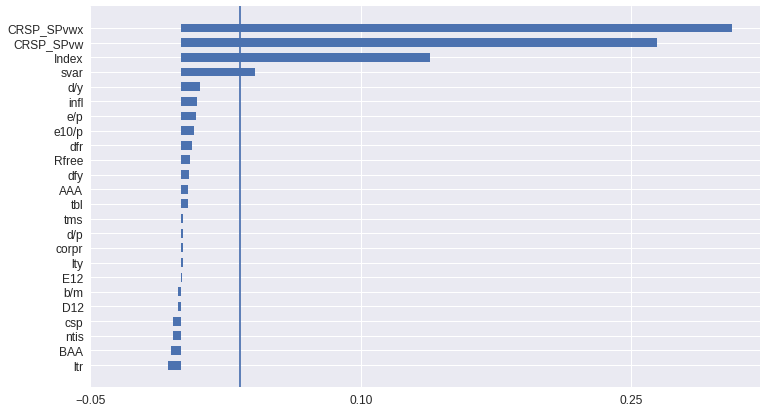

In [107]:
clf = RandomForestClassifier()
all_importances, all_imp_scr1 = featImpMDA_classif(clf, X_train, y_train, cv=10, seed=1)

start MDA 2022-02-05 23:33:50.972848
end MDA 2022-02-05 23:33:56.247486


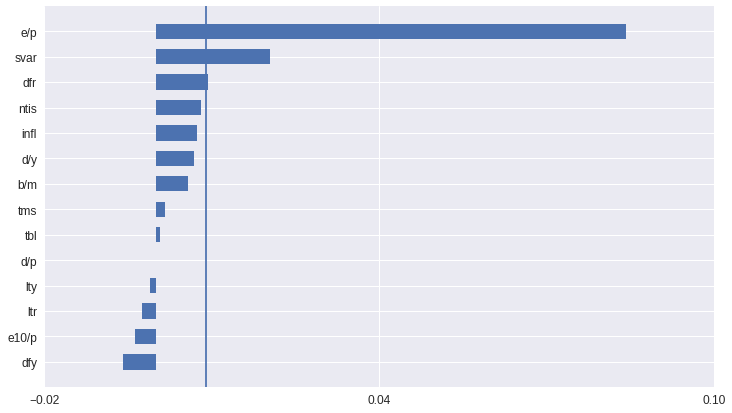

In [108]:
paper_importances, paper_imp_scr1 = featImpMDA_classif(clf, paper_X_train, y_train, cv=10, seed=1)

# Question 2

If you obtain a different FI score for a feature in each cross validation subset, how is the overall FI score computed? (1 pt)

Per the coding discussion post this week by our TA, we were asked to use negative log loss from the book exercises instead of F1. The negative log loss is computed across the ij for each CV fold (rows), then when CV is complete all 10 folds are averaged for each feature (columns.mean())

The example below shows the 10 CV values for each of the features. They do differ. 

In [81]:
all_imp_scr1

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,csp,CRSP_SPvw,CRSP_SPvwx,dfy,dfr,d/p,d/y,e/p,e10/p,tms
0,-0.342115,-0.306614,-0.306966,-0.312802,-0.312669,-0.312074,-0.312782,-0.314816,-0.310843,-0.315363,...,-0.316582,-0.41472,-0.4343,-0.309857,-0.315435,-0.313627,-0.31626,-0.308854,-0.313554,-0.307867
1,-0.317134,-0.258822,-0.259415,-0.263104,-0.259473,-0.258667,-0.258516,-0.26183,-0.250434,-0.262027,...,-0.262327,-0.417986,-0.41226,-0.263693,-0.258926,-0.264018,-0.264638,-0.253819,-0.263053,-0.256966
2,-0.327459,-0.291865,-0.295667,-0.287868,-0.294461,-0.293333,-0.286126,-0.28844,-0.294941,-0.288159,...,-0.275642,-0.413046,-0.362752,-0.295346,-0.291244,-0.297038,-0.307803,-0.286096,-0.29472,-0.296151
3,-0.509075,-0.377986,-0.376447,-0.372806,-0.376188,-0.375897,-0.371855,-0.377425,-0.368466,-0.381505,...,-0.369459,-0.433029,-0.441414,-0.378473,-0.371311,-0.376724,-0.376414,-0.371413,-0.384327,-0.374203
4,-0.436156,-0.297532,-0.296916,-0.29418,-0.293095,-0.297407,-0.286409,-0.293004,-0.291868,-0.292034,...,-0.292217,-0.422032,-0.463677,-0.293292,-0.299956,-0.291724,-0.285399,-0.298355,-0.289532,-0.295283
5,-0.336041,-0.278503,-0.283011,-0.286627,-0.2865,-0.283668,-0.287244,-0.284313,-0.297944,-0.290212,...,-0.285674,-0.39341,-0.428029,-0.288409,-0.289956,-0.283826,-0.286178,-0.282085,-0.286167,-0.283609
6,-0.360771,-0.344423,-0.345638,-0.339759,-0.341522,-0.346207,-0.346533,-0.345602,-0.343367,-0.345999,...,-0.34672,-0.462701,-0.62412,-0.348097,-0.345522,-0.345591,-0.343811,-0.345047,-0.337476,-0.352166
7,-0.337551,-0.294142,-0.303456,-0.305088,-0.308398,-0.305844,-0.294832,-0.300548,-0.296903,-0.303242,...,-0.305309,-0.41921,-0.47484,-0.292152,-0.305401,-0.295174,-0.299364,-0.310649,-0.307116,-0.302626
8,-0.393349,-0.395152,-0.385701,-0.384858,-0.388497,-0.386772,-0.389193,-0.38754,-0.385354,-0.387105,...,-0.384448,-0.460466,-0.498407,-0.390952,-0.387582,-0.390014,-0.393558,-0.410149,-0.392248,-0.386452
9,-0.391117,-0.357704,-0.352617,-0.350764,-0.355674,-0.357246,-0.355632,-0.354947,-0.349803,-0.355211,...,-0.353499,-0.514841,-0.524298,-0.360192,-0.357736,-0.350661,-0.366293,-0.373688,-0.361601,-0.35427


# Question 3

What are the 5 most important features? What are the features with above-average FI scores? (2 pt)

## Answer

The five most important features for All: are CRSP_SPvwx, CRSP_SPvw, Index, svar, Rfree
The five most important features for the features from the paper only: e/p, svar, dfr, rtis, infl

Only these features were above average imporance: all (CRSP_SPvwx, CRSP_SPvw, Index, svar) and paper (e/p, svar, dfr)

See plots above where the vertical line denotes the mean importance

# Question 4

If you use only those above-average features as input, and retrain a RF as in the Module 4 assignment to predict the same labels, do any of the performance metrics improve? (2 pt) 

## Answer

Using the above average features for both did not improve my overall F1 or AUC from assignment 4
                    
previous assignment- F1: 54.6% AUC 0.54

above average all - F1: 38% AUC 0.31

above average paper - F1: 53.2% AUC 0.53


In [76]:
#Chosing only above average features
all_important_train = X_train[['CRSP_SPvwx', 'CRSP_SPvw', 'Index', 'svar']]
all_important_test = X_test[['CRSP_SPvwx', 'CRSP_SPvw', 'Index', 'svar']]

paper_important_train = paper_X_train[['e/p', 'svar', 'dfr']]
paper_important_test = X_test[['e/p', 'svar', 'dfr']]

Untuned Hyperparmeters 
Train F1: 0.5461052879039213, Test F1: 0.5463266958070261
One-vs-One Test ROC AUC scores:
0.540260 (macro), 0.540260 (weighted by prevalence)
One-vs-Rest Test ROC AUC scores:
0.540260 (macro),0.540260 (weighted by prevalence)


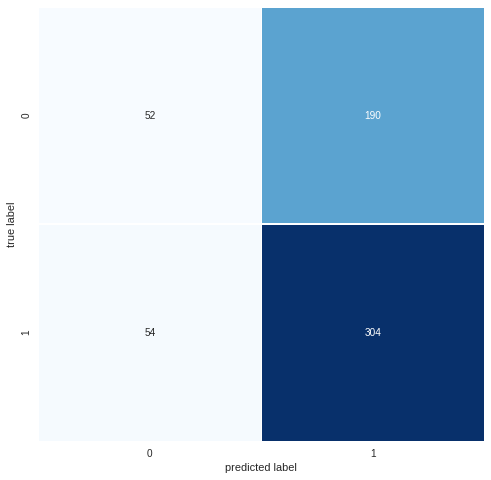

In [77]:
## Original Assigment:
rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(X_train[:-1],np.array(y_train.iloc[1:]).ravel())
y_hat = rf.predict(X_test)
y_hat_train = rf.predict(X_train)
test_f1 = f1_score(y_test, y_hat, average='weighted')
train_f1 = f1_score(y_train, y_hat_train, average='weighted')
y_prob = rfclf.predict_proba(X_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(y_test),  y_prob[:,1], multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                  y_prob[:,1], 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {train_f1}, Test F1: { test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(y_test, y_hat)

Untuned Hyperparmeters 
Train F1: 0.5444444444444444, Test F1: 0.38666666666666666
One-vs-One Test ROC AUC scores:
0.316260 (macro), 0.316260 (weighted by prevalence)
One-vs-Rest Test ROC AUC scores:
0.316260 (macro),0.316260 (weighted by prevalence)


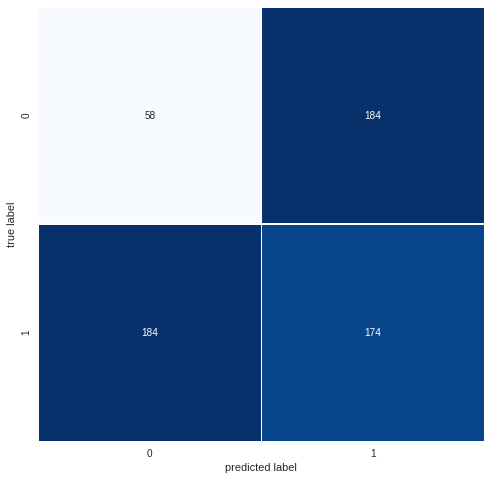

In [79]:
# Above average features across  all features 
rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(all_important_train[:-1],np.array(y_train.iloc[1:]).ravel())
y_hat = rf.predict(all_important_test)
y_hat_train = rf.predict(all_important_train)
test_f1 = f1_score(y_test, y_hat, average='weighted')
train_f1 = f1_score(y_train, y_hat_train, average='weighted')
y_prob = rfclf.predict_proba(all_important_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), y_prob[:,1], multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                  y_prob[:,1], 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {train_f1}, Test F1: { test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(y_test, y_hat)

Untuned Hyperparmeters 
Train F1: 0.5461052879039213, Test F1: 0.5325788236575679
One-vs-One Test ROC AUC scores:
0.531407 (macro), 0.531407 (weighted by prevalence)
One-vs-Rest Test ROC AUC scores:
0.531407 (macro),0.531407 (weighted by prevalence)


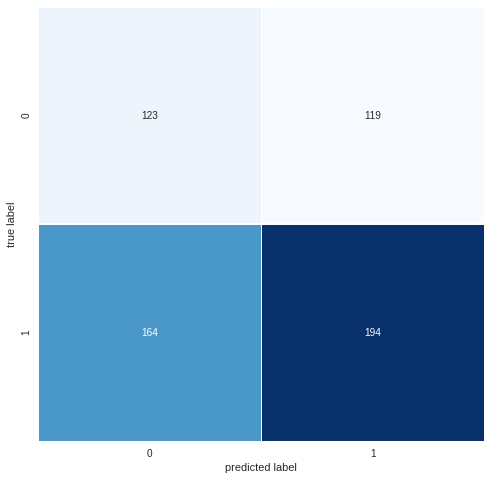

In [64]:
# Above average features from the paper
rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(paper_important_train[:-1],np.array(y_train.iloc[1:]).ravel())
y_hat = rf.predict(paper_important_test)
y_hat_train = rf.predict(paper_important_train)
test_f1 = f1_score(y_test, y_hat, average='weighted')
train_f1 = f1_score(y_train, y_hat_train, average='weighted')
y_prob= rfclf.predict_proba(paper_important_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), y_prob[:,1], multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                  y_prob[:,1], 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {train_f1}, Test F1: { test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(y_test, y_hat)


# Question 5

Now set the random seed to 2, and recompute #3. Are they different? (Hint: see Man, Xin and Chan, Ernest. 2020

## Answer:

e/p and svar are still in the same position but infl and rtis have changed positions as discussed by Man and Chan (2021) MDA  is highly unstable without a long run simulation. Also there are four above average features when using seed 2 compared to the three in seed 1. 

start MDA 2022-02-05 23:34:07.804295
end MDA 2022-02-05 23:34:12.876710


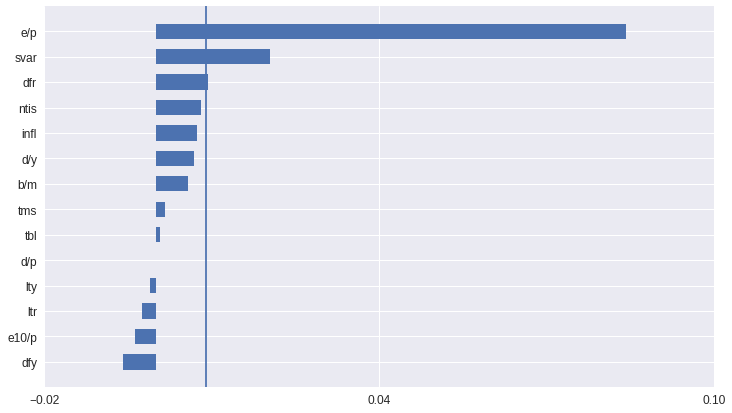

In [109]:
#Question 3 importances - seed 1
paper_importances, paper_imp_scr1 = featImpMDA_classif(clf, paper_X_train, y_train, cv=10, seed=1)


start MDA 2022-02-05 23:34:13.060887
end MDA 2022-02-05 23:34:18.146971


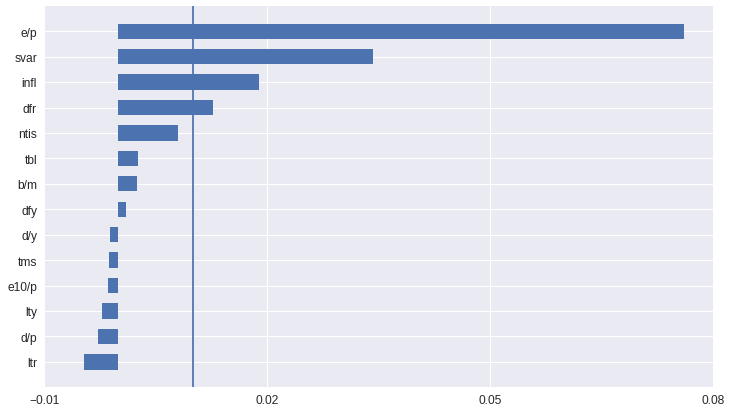

In [110]:
#Question 5 importances - seed 2
paper_importances, paper_imp_scr1 = featImpMDA_classif(clf, paper_X_train, y_train, cv=10, seed=2)


## Question 6

Retrain your RF model using the above-average features obtained in #5. Do any of the performance metrics improve over the Module 4 results? How do these metrics compare to those in #4 above? (2 pt)

## Answer

This seed is worse than the previous by nearly six points measured by the F1 score and 3 points by AUC. 


With seed two - F1: 47% AUC 0.5

With seed one: 
above average all - F1: 38% AUC 0.31
above average paper - F1: 53.2% AUC 0.53

In [86]:
new_paper_important_train = paper_X_train[['e/p', 'svar', 'dfr', 'infl']]
new_paper_important_test = X_test[['e/p', 'svar', 'dfr', 'infl']]

In [ ]:
# Above average features from the paper
rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(paper_important_train[:-1],np.array(y_train.iloc[1:]).ravel())
y_hat = rf.predict(paper_important_test)
y_hat_train = rf.predict(paper_important_train)
test_f1 = f1_score(y_test, y_hat, average='weighted')
train_f1 = f1_score(y_train, y_hat_train, average='weighted')
y_prob= rfclf.predict_proba(paper_important_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), y_prob[:,1], multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                  y_prob[:,1], 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {train_f1}, Test F1: { test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(y_test, y_hat)

Untuned Hyperparmeters 
Train F1: 0.5461052879039213, Test F1: 0.4704984683932052
One-vs-One Test ROC AUC scores:
0.507081 (macro), 0.507081 (weighted by prevalence)
One-vs-Rest Test ROC AUC scores:
0.507081 (macro),0.507081 (weighted by prevalence)


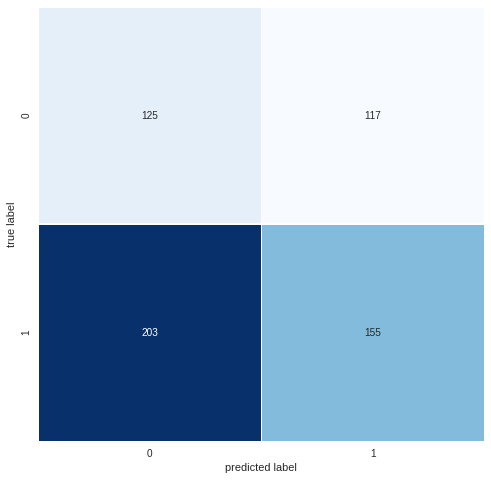

In [89]:
# Above average features from the paper
rfclf = RandomForestClassifier(random_state=1)
rf = rfclf.fit(new_paper_important_train[:-1],np.array(y_train.iloc[1:]).ravel())
y_hat = rf.predict(new_paper_important_test)
y_hat_train = rf.predict(new_paper_important_train)
test_f1 = f1_score(y_test, y_hat, average='weighted')
train_f1 = f1_score(y_train, y_hat_train, average='weighted')
y_prob= rfclf.predict_proba(new_paper_important_test)
untuned_macro_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), y_prob[:,1], multi_class="ovo", average="macro")
untuned_weighted_roc_auc_ovo = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovo", 
                                     average="weighted"
)
untuned_macro_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                  y_prob[:,1], 
                                  multi_class="ovr", 
                                  average="macro"
)
untuned_weighted_roc_auc_ovr = roc_auc_score(np.array(y_test).ravel(), 
                                     y_prob[:,1], 
                                     multi_class="ovr", 
                                     average="weighted"
)
print(f'Untuned Hyperparmeters \nTrain F1: {train_f1}, Test F1: { test_f1}')
print("One-vs-One Test ROC AUC scores:\n{:.6f} (macro), {:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovo, untuned_weighted_roc_auc_ovo))
print("One-vs-Rest Test ROC AUC scores:\n{:.6f} (macro),{:.6f} "
    "(weighted by prevalence)".format(untuned_macro_roc_auc_ovr, untuned_weighted_roc_auc_ovr))
plot_confusion_matrix(y_test, y_hat)